# ***超参数调试、Batch正则化和编程框架***

# 1. 超参数

① 深度神经网络需要调试的超参数（Hyperparameters）较多，包括：

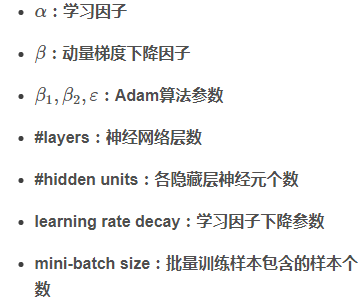

① 超参数之间也有重要性差异。

② 通常来说，学习因子α是最重要的超参数，也是需要重点调试的超参数。

③ 动量梯度下降因子β、各隐藏层神经元个数#hidden units和mini-batch size的重要性仅次于α。

④ 然后就是神经网络层数#layers和学习因子下降参数learning rate decay。

⑤ Adam算法的三个参数β1,β2,ε一般常设置为0.9，0.999和10^−8，不需要反复调试。

⑥ 当然，这里超参数重要性的排名并不是绝对的，具体情况，具体分析。

① 如何选择和调试超参数？传统的机器学习中，我们对每个参数等距离选取任意个数的点，然后，分别使用不同点对应的参数组合进行训练，最后根据验证集上的表现好坏，来选定最佳的参数。

② 例如有两个待调试的参数，分别在每个参数上选取5个点，这样构成了5x5=25中参数组合，如下图所示：

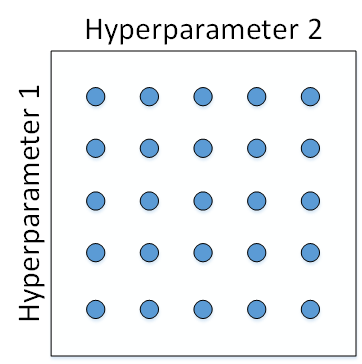

① 这种做法在参数比较少的时候效果较好。但是在深度神经网络模型中，我们一般不采用这种均匀间隔取点的方法，比较好的做法是使用随机选择。

② 也就是说，对于上面这个例子，我们随机选择25个点，作为待调试的超参数，如下图所示：

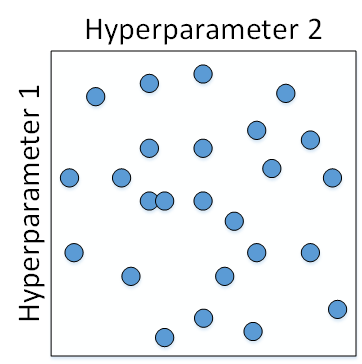

③ 随机化选择参数的目的是为了尽可能地得到更多种参数组合。还是上面的例子，如果使用均匀采样的话，每个参数只有5种情况；而使用随机采样的话，每个参数有25种可能的情况，因此更有可能得到最佳的参数组合。

① 这种做法带来的另外一个好处就是对重要性不同的参数之间的选择效果更好。假设hyperparameter1为α，hyperparameter2为ε，显然二者的重要性是不一样的。

② 如果使用第一种均匀采样的方法，ε的影响很小，相当于只选择了5个α值。而如果使用第二种随机采样的方法，ε和α都有可能选择25种不同值。这大大增加了α调试的个数，更有可能选择到最优值。

③ 其实，在实际应用中完全不知道哪个参数更加重要的情况下，随机采样的方式能有效解决这一问题，但是均匀采样做不到这点。

① 在经过随机采样之后，我们可能得到某些区域模型的表现较好。

② 然而，为了得到更精确的最佳参数，我们应该继续对选定的区域进行由粗到细的采样（coarse to fine sampling scheme）。也就是放大表现较好的区域，再对此区域做更密集的随机采样。

③ 例如，对下图中右下角的方形区域再做25点的随机采样，以获得最佳参数。

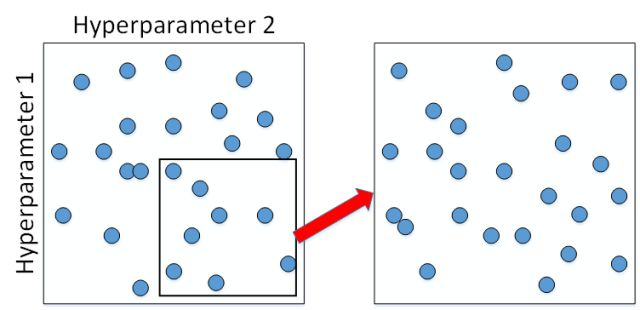

① 上一部分讲的调试参数使用随机采样，对于某些超参数是可以进行尺度均匀采样的，但是某些超参数需要选择不同的合适尺度进行随机采样。

② 什么意思呢？例如对于超参数#layers和#hidden units，都是正整数，是可以进行均匀随机采样的，即超参数每次变化的尺度都是一致的（如每次变化为1，犹如一个刻度尺一样，刻度是均匀的）。

③ 但是，对于某些超参数，可能需要非均匀随机采样（即非均匀刻度尺）。例如超参数α，待调范围是[0.0001, 1]。如果使用均匀随机采样，那么有90%的采样点分布在[0.1, 1]之间，只有10%分布在[0.0001, 0.1]之间。

④ 这在实际应用中是不太好的，因为最佳的α值可能主要分布在[0.0001, 0.1]之间，而[0.1, 1]范围内α值效果并不好。因此我们更关注的是区间[0.0001, 0.1]，应该在这个区间内细分更多刻度。

⑤ 通常的做法是将linear scale转换为log scale，将均匀尺度转化为非均匀尺度，然后再在log scale下进行均匀采样。这样，[0.0001, 0.001]，[0.001, 0.01]，[0.01, 0.1]，[0.1, 1]各个区间内随机采样的超参数个数基本一致，也就扩大了之前[0.0001, 0.1]区间内采样值个数。

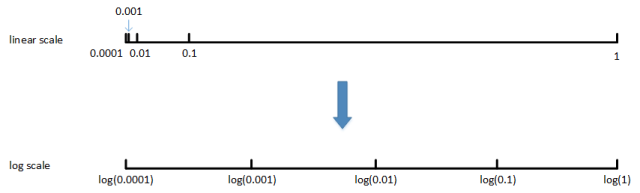

① 一般解法是，如果线性区间为[a, b]，令m=log(a)，n=log(b)，则对应的log区间为[m,n]。

② 对log区间的[m,n]进行随机均匀采样，然后得到的采样值r，最后反推到线性区间，即10^r。

③ 10^r就是最终采样的超参数。相应的Python语句为：

In [ ]:
m = np.log10(a)
n = np.log10(b)
r = np.random.rand()
r = m +(n-m)*r
r = np.power(10,r)

① 除了α之外，动量梯度因子β也是一样，在超参数调试的时候也需要进行非均匀采样。

② 一般β的取值范围在[0.9, 0.999]之间，那么1−β的取值范围就在[0.001, 0.1]之间。那么直接对1−β在[0.001, 0.1]区间内进行log变换即可。

③ 这里解释下为什么β也需要向α那样做非均匀采样。假设β从0.9000变化为0.9005，那么1/(1−β)基本没有变化。但假设β从0.9990变化为0.9995，那么1/(1−β)前后差别1000。β越接近1，指数加权平均的个数越多，变化越大。所以对β接近1的区间，应该采集得更密集一些。

① 经过调试选择完最佳的超参数并不是一成不变的，一段时间之后（例如一个月），需要根据新的数据和实际情况，再次调试超参数，以获得实时的最佳模型。

② 在训练深度神经网络时，一种情况是受计算能力所限，我们只能对一个模型进行训练，调试不同的超参数，使得这个模型有最佳的表现。我们称之为Babysitting one model。

③ 另外一种情况是可以对多个模型同时进行训练，每个模型上调试不同的超参数，根据表现情况，选择最佳的模型。我们称之为Training many models in parallel。

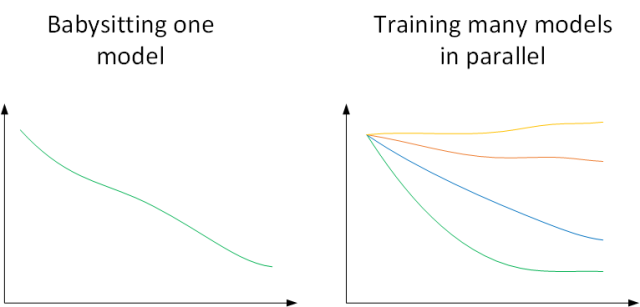

④ 因为第一种情况只使用一个模型，所以类比做Panda approach；第二种情况同时训练多个模型，类比做Caviar approach。

⑤ 使用哪种模型是由计算资源、计算能力所决定的。一般来说，对于非常复杂或者数据量很大的模型，使用Panda approach更多一些。

# 2. 批标准化

① Sergey Ioffe和Christian Szegedy两位学者提出了Batch Normalization方法。

② Batch Normalization不仅可以让调试超参数更加简单，而且可以让神经网络模型更加“健壮”。也就是说较好模型可接受的超参数范围更大一些，包容性更强，使得更容易去训练一个深度神经网络。

③ 接下来，我们就来介绍什么是Batch Normalization，以及它是如何工作的。

① 之前，我们在前面的笔记中提到过在训练神经网络时，标准化输入可以提高训练的速度。方法是对训练数据集进行归一化的操作，即将原始数据减去其均值μ后，再除以其方差σ^2。

② 但是标准化输入只是对输入进行了处理，那么对于神经网络，又该如何对各隐藏层的输入进行标准化处理呢？

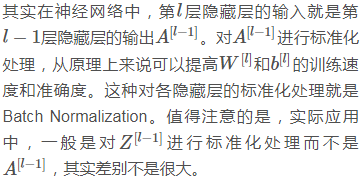

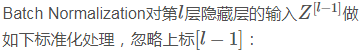

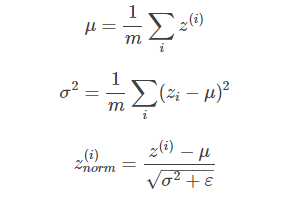

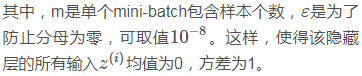

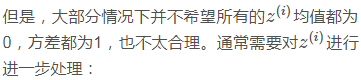

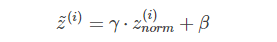

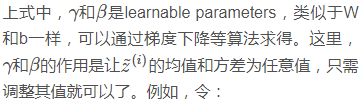

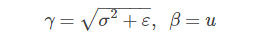

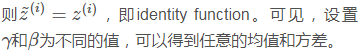

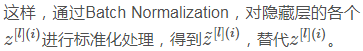

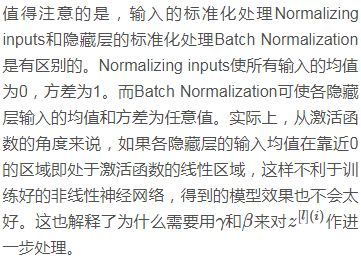

① 我们已经知道了如何对某单一隐藏层的所有神经元进行Batch Norm，接下来将研究如何把Bath Norm应用到整个神经网络中。

② 对于L层神经网络，经过Batch Norm的作用，整体流程如下：

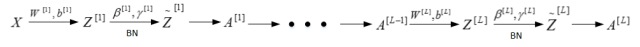

③ 实际上，Batch Norm经常使用在mini-batch上，这也是其名称的由来。

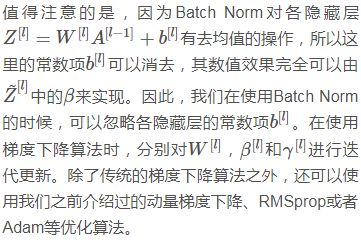

① 我们可以把输入特征做均值为0，方差为1的规范化处理，来加快学习速度。

② 而Batch Norm也是对隐藏层各神经元的输入做类似的规范化处理。

③ 总的来说，Batch Norm不仅能够提高神经网络训练速度，而且能让神经网络的权重W的更新更加“稳健”，尤其在深层神经网络中更加明显。

④ 比如神经网络很后面的W对前面的W包容性更强，即前面的W的变化对后面W造成的影响很小，整体网络更加健壮。

① 举个例子来说明，假如用一个浅层神经网络（类似逻辑回归）来训练识别猫的模型。如下图所示，提供的所有猫的训练样本都是黑猫。

② 然后，用这个训练得到的模型来对各种颜色的猫样本进行测试，测试的结果可能并不好。

③ 其原因是训练样本不具有一般性（即不是所有的猫都是黑猫），这种训练样本（黑猫）和测试样本（猫）分布的变化称之为covariate shift。

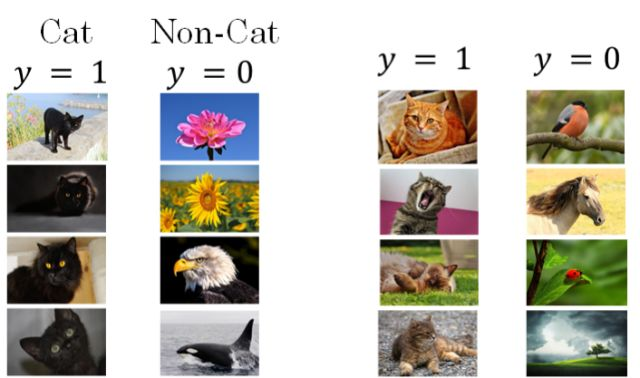

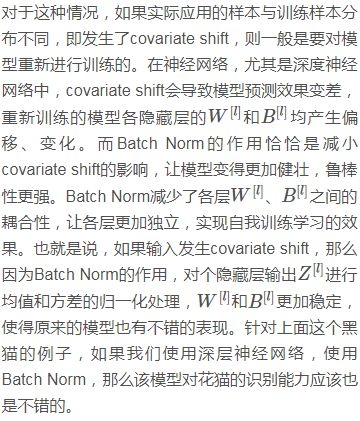

① 从另一个方面来说，Batch Norm也起到轻微的正则化（regularization）效果。具体表现在：

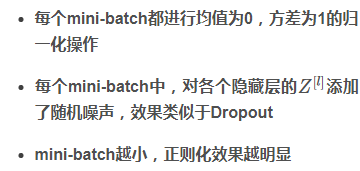

② 但是，Batch Norm的正则化效果比较微弱，正则化也不是Batch Norm的主要功能。

① 训练过程中，Batch Norm是对单个mini-batch进行操作的，但在测试过程中，如果是单个样本，该如何使用Batch Norm进行处理呢？

② 首先，回顾一下训练过程中Batch Norm的主要过程：

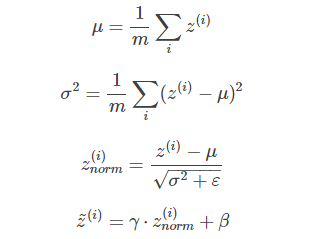

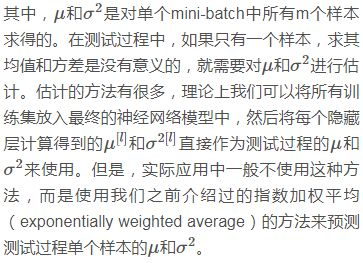

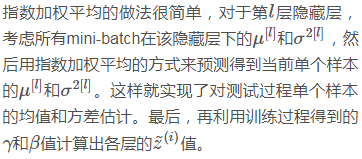

# 3. Softmax回归

① 目前我们介绍的都是二分类问题，神经网络输出层只有一个神经元，表示预测输出y^是正类的概率P(y=1|x)，y^>0.5则判断为正类，y^<0.5则判断为负类。

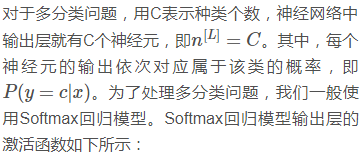

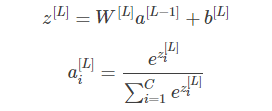

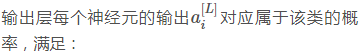

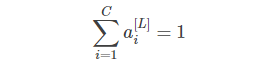

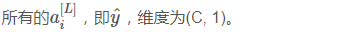

② 下面给出几个简单的线性多分类的例子：

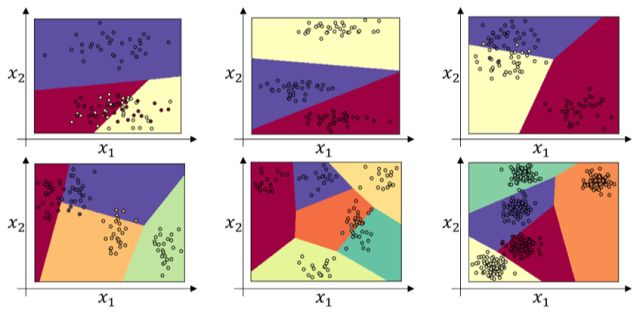

③ 如果使用神经网络，特别是深层神经网络，可以得到更复杂、更精确的非线性模型。

① Softmax classifier的训练过程与我们之前介绍的二元分类问题有所不同。先来看一下softmax classifier的loss function。

② 举例来说，假如C=4，某个样本的预测输出y^和真实输出y为：

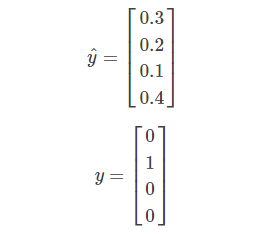

③ 从y^值来看，P(y=4|x)=0.4，概率最大，而真实样本属于第2类，因此该预测效果不佳。

④ 我们定义softmax classifier的loss function为：

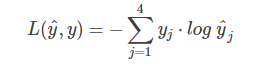

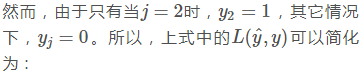

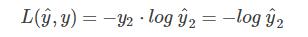

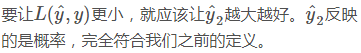

⑤ 所有m个样本的cost function为：

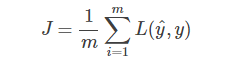

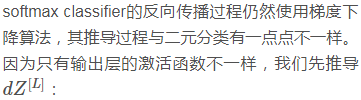

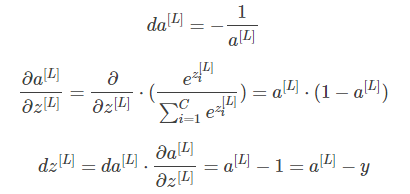

⑥ 对于所有m个训练样本：

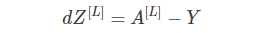

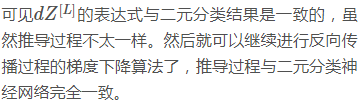

# 4. 深度学习框架

① 深度学习框架有很多，例如：
 - Caffe/Caffe2
 - CNTK
 - DL4J
 - Keras
 - Lasagne
 - mxnet
 - PaddlePaddle
 - TensorFlow
 - Theano
 - Torch
  
② 一般选择深度学习框架的基本准则是：
 - Ease of programming(development and deployment)
 - Running speed
 - Truly open(open source with good governance)
 
③ 实际应用中，我们应该根据自己的需求选择最合适的深度学习框架。

# 5. TensorFlow

① 这里简单介绍一下最近几年比较火的一个深度学习框架：TensorFlow。

② 举个例子来说明，例如cost function是参数w的函数：

③ 如果使用TensorFlow对cost function进行优化，求出最小值对应的w，程序如下：

In [1]:
import numpy as np
import tensorflow as tf
w = tf.Variable(0,dtype=tf.float32)
#cost = tf.add(tf.add(w**2,tf.multiply(-10,w)),25)
cost = w**2 - 10*w + 25
train = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

init = tf.global_variables_initializer()
session = tf.Session()
session.run(init)

print(session.run(w))

D:\11_Anaconda\envs\py3.6.3\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


0.0


In [2]:
session.run(train)
print(session.run(w))

0.099999994


In [3]:
for i in range(1000):
    session.run(train)
print(session.run(w))

4.9999886


① TensorFlow框架内可以直接调用梯度下降优化算法，不需要我们自己再写程序了，大大提高了效率。在运行1000次梯度下降算法后，w的解为4.99999，已经非常接近w的最优值5了。

② 针对上面这个例子，如果对w前的系数用变量x来代替，程序如下：

In [4]:
import numpy as np
import tensorflow as tf

w = tf.Variable(0,dtype=tf.float32)
x = tf.placeholder(tf.float32,[3,1])
#cost = tf.add(tf.add(w**2,tf.multiply(-10,w)),25)
#cost = w**2 - 10*w +25
cost = x[0][0]*w**2 + x[1][0]*w + x[2][0]
train = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

init = tf.global_variables_initializer()
session = tf.Session()
session.run(init)
print(session.run(w))

0.0


In [5]:
coefficients = np.array([1,-10,25]).reshape(3, 1)
session.run(train, feed_dict={x: coefficients})
print(session.run(w))

0.099999994


In [6]:
for i in range(1000):
    session.run(train, feed_dict={x: coefficients})
print(session.run(w))

4.9999886


① 结果跟之前是一样的。除此之外，我们还可以更改x即cofficients的值，而得到不同的优化结果w。

② 另外，上段程序中的：

In [7]:
session = tf.Session()
session.run(init)
print(session.run(w))

0.0


In [8]:
with tf.Session() as session:
    session.run(init)
    print(session.run(w))

0.0


① TensorFlow的最大优点就是采用数据流图（data flow graphs）来进行数值运算。

② 图中的节点（Nodes）表示数学操作，图中的线（edges）则表示在节点间相互联系的多维数据数组，即张量（tensor）。

③ 而且它灵活的架构让你可以在多种平台上展开计算，例如台式计算机中的一个或多个CPU（或GPU），服务器，移动设备等等。

④ 关于TensorFlow更多的原理和编程技巧这里就不在赘述了，感兴趣的朋友可以关注更详细的TensorFlow相关文档。